In [1]:
import pandas as pd
from sklearn import svm
import numpy as np
import shap
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from keras.optimizers import Adam
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from sklearn.ensemble import ExtraTreesClassifier
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm

In [2]:
import sys
sys.path.append('..')
sys.path.append('../../')
from util import Transform, PredictWay, get_k_fold_data, dnn
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Microsoft YaHei']
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import permutation_test_score
from metric import getMATRIX

In [ ]:
'''
preturn
'''

MATRIX = []
def str2Nan(x):
    try:
        return float(x)
    except:
        return np.nan
seed=4 
patient = pd.read_excel('../../)
# put into the data


transform = Transform(seed_num=seed)
patient = transform.confuse(patient) 
# X, Y = transform.drop(patient,startXIndex=0,YIndex=2,dropColunm=['肿瘤1，结核4，慢性炎症2，急性炎症3，漏出液0'])    
# X, Y = transform.drop(patient,startXIndex=0,YIndex=3,dropColunm=['恶性1，良性0'])    
X, Y = transform.drop(patient,startXIndex=0,YIndex=-1,dropColunm=['Y'])    

for name in X.columns:
    X[name] = X[name].apply(str2Nan)
    X[name] = X[name].fillna(X[name].median())

In [5]:
'''
kfold
'''
k = 10
X = transform.normalization(X)
result_svm, result_gbdt,result_tree,result_randomtree,result_lg,result_knn,result_lgb = [],[], [], [],[],[],[]
false_index = []
test_x, test_y = X[-200:],Y[-200:]
X, Y = X[:-200],Y[:-200]


第5代
SVM P: TtestResult(statistic=-0.3575959801292518, pvalue=0.7209170209262061, df=278.0)
DT P: TtestResult(statistic=0.238214766019969, pvalue=0.8118900132834765, df=278.0)
GBDT P: TtestResult(statistic=-0.5966034491264511, pvalue=0.5512576837600403, df=278.0)
RF P: TtestResult(statistic=-0.3575959801292518, pvalue=0.7209170209262061, df=278.0)
KNN P: TtestResult(statistic=-0.23831207597746815, pvalue=0.811814619353582, df=278.0)
LR P: TtestResult(statistic=0.0, pvalue=1.0, df=278.0)
XGB P: TtestResult(statistic=-0.23831207597746815, pvalue=0.811814619353582, df=278.0)
ET P: TtestResult(statistic=0.4766241519549363, pvalue=0.6340041935802325, df=278.0)


Exception in thread Thread-11:
Traceback (most recent call last):
  File "d:\Anaconda\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "d:\Anaconda\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "d:\Anaconda\lib\subprocess.py", line 1495, in _readerthread
    buffer.append(fh.read())
  File "d:\Anaconda\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xd3 in position 24: invalid continuation byte


Ada P: TtestResult(statistic=-0.9567730631563374, pvalue=0.3395130927132053, df=278.0)


  File "d:\Anaconda\lib\site-packages\joblib\externals\loky\backend\context.py", line 262, in _count_physical_cores
    cpu_info = cpu_info.stdout.splitlines()


LightGBM P: TtestResult(statistic=-0.23831207597746815, pvalue=0.811814619353582, df=278.0)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
DNN P: TtestResult(statistic=array([-1.05133652, -1.05133652, -1.05133652, -1.05133652, -1.05133652,
       -1.05133652,  0.93767852, -1.05133652, -1.05133652, -1.05133652,
        0.93767852,  0.93767852,  0.93767852, -1.05133652,  0.93767852,
        0.93767852,  0.93767852, -1.05133652, -1.05133652, -1.05133652,
        0.93767852,  0.93767852, -1.05133652, -1.05133652,  0.93767852,
       -1.05133652, -1.05133652,  0.93767852,  0.93767852,  0.93767852,
        0.93767852,  0.93767852, -1.05133652, -1.05133652,  0.93767852,
       -1.05133652, -1.05133652,  0.93767852,  0.93767852, -1.05133652,
        0.93767852,  0.93767852, -1.05133652,  0.93767852,  0.93767852,
        0.93767852, -1.05133652, -1.05133652, -1.05133652,  0.93767852,
        0.93767852, -1.05133652,  0.93767852,  0.93767852,  0.93767852,
        0.93767852,  0.93767852, -1.05133652,  0.

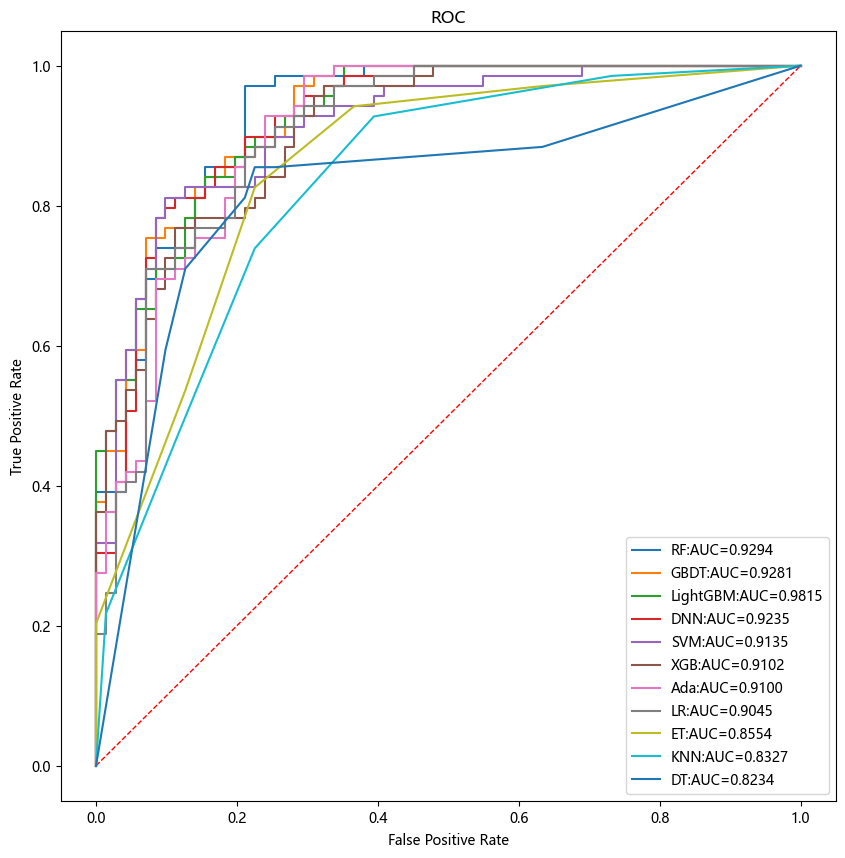

In [6]:
ModelDict = {
    'SVM':svm.SVC(random_state=seed, probability=True),
    'DT':DecisionTreeClassifier(max_depth=10,
                                          random_state=seed),
    'GBDT':GradientBoostingClassifier(random_state=seed),
    'RF':RandomForestClassifier(random_state=seed,
                                          min_samples_leaf=10),
    'KNN':KNeighborsClassifier(),
    'LR':LogisticRegression(random_state=400,max_iter=100),
    'XGB':XGBClassifier(),
    'ET':ExtraTreesClassifier(n_estimators=5, random_state=42),
    'Ada':AdaBoostClassifier(n_estimators=50, random_state=42),
    'LightGBM':lgb.LGBMClassifier(num_leaves=400,random_state=42,verbosity=-1),
    'DNN':dnn}  
for i in range(k):
    if i!=4:
        continue
    print('第{:d}代'.format(i+1))
    X_train, y_train, x_valid, y_valid,Y_index = get_k_fold_data(k,i,X,Y,transform.confuse_index)
    pre = PredictWay(X_train, y_train, x_valid, y_valid,seed,Y_index)
    for model_name, model in ModelDict.items():
        matric = pre.model_train(model_name, model)
        if model_name=='LightGBM':
            model_shap = pre.model_fit
    pre.show_roc()


In [7]:
result = {
    'LightGBM':[]
}

'''
获取特征重要性
'''
temp = model_shap.feature_importances_[:]
print(temp)
importance = []
for i in range(len(temp)):
    importance.append(temp.argmax())
    temp[temp.argmax()]=-1
importance.reverse()

[179 152 178 112 135 176 145 182 123 130 111 464 339 119 160 133 127 159
 179 187 130 150 248 225 101 119 279 199]


In [9]:
X[X.columns[importance[-10:]]]

,TCH,age,T,TG,GSP,apo-AI,Glu,LPa,AMH,DHEAS
0,0.561514,0.360828,-0.329860,1.804851,-0.141691,-0.322424,0.243640,-0.874800,0.147518,2.145939
1,-1.201557,0.360828,-0.668563,-0.631103,-0.826752,-0.520839,0.233366,-0.829565,-1.021471,-0.709760
2,-0.806702,-0.756780,0.745522,-0.424666,-0.190624,0.024802,-0.331700,0.509385,0.641316,0.511019
3,-0.191464,1.318777,-0.685498,-0.269839,-1.071417,-1.116084,-0.454987,-0.259606,-0.572015,0.337425
4,1.075743,-0.756780,0.372949,-0.693034,-0.973551,0.272821,0.048435,0.663183,1.195578,0.318538
...,...,...,...,...,...,...,...,...,...,...
1395,0.139112,0.520486,-0.075832,2.351909,0.739101,-0.074406,2.031301,-0.603391,-0.588139,-0.569803
1396,0.836994,0.360828,0.152792,-0.579494,0.200839,0.570443,0.151174,0.228929,-0.245504,-0.157783
1397,0.028920,-0.277805,0.135857,-0.889149,-0.239557,-1.016877,-0.187865,0.247023,-0.366434,-1.255795
1398,0.102381,-0.277805,-0.067365,0.463012,-1.218215,-0.719254,0.634048,-0.060573,-0.376512,-0.688326


第1代
LightGBM P: TtestResult(statistic=-0.6752078438794228, pvalue=0.49982341200961333, df=558.0)
外部验证集 最终模型auc： 0.9449779911964786
第2代
LightGBM P: TtestResult(statistic=0.9294436525209273, pvalue=0.3530611092636168, df=558.0)
外部验证集 最终模型auc： 0.9372749099639855
第3代
LightGBM P: TtestResult(statistic=-0.6765912553464316, pvalue=0.4989456876995685, df=558.0)
外部验证集 最终模型auc： 0.9451780712284914
第4代
LightGBM P: TtestResult(statistic=1.3555128571831725, pvalue=0.1758026005109639, df=558.0)
外部验证集 最终模型auc： 0.9330732292917167
第5代
LightGBM P: TtestResult(statistic=0.4219564242844226, pvalue=0.6732193418540864, df=558.0)
外部验证集 最终模型auc： 0.9261704681872749
[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.313

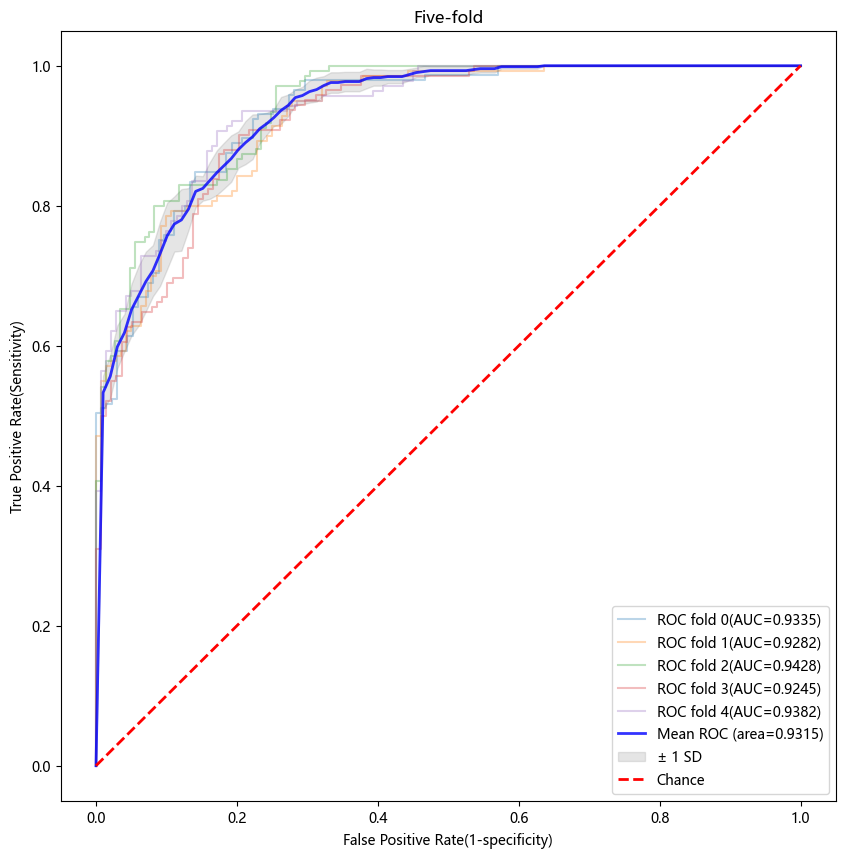

In [ ]:
'''
绘制kfold的roc
'''
from sklearn.metrics import roc_curve, auc
roc_lgbs = []
X_in = X.drop(X.columns[importance[:12]],axis=1)  
X_test_drop = test_x.drop(X.columns[importance[:12]],axis=1)
k = 5
false_index = []
for i in range(k):
    print('第{:d}代'.format(i+1))
    X_train, y_train, x_valid, y_valid,Y_index = get_k_fold_data(k,i,X_in,Y,transform.confuse_index)
    pre = PredictWay(X_train, y_train, x_valid, y_valid,seed,Y_index)
    pre.show = False
    pre.model_train('LightGBM',ModelDict['LightGBM'])
    f,t = pre.dict_auc['LightGBM']
    roc_lgbs.append([f,t])
    result = np.array(pre.model_fit.predict_proba(X_test_drop))[:, 1]
    f, t, th = roc_curve(test_y, result)
    print('外部验证集 最终模型auc：', auc(f,t)) 

plt.figure(figsize=(10,10))
tprs = []
mean_fpr = np.linspace(0,1,100)
for index, i in enumerate(roc_lgbs):
    plt.plot(i[0],i[1], alpha = 0.3, label=f'ROC fold {index}(AUC={auc(i[0],i[1]):.4f})')
    # sum0 += i[0]
    # sum1 += i[1]
    tprs.append(np.interp(mean_fpr, i[0], i[1]))
    tprs[-1][0] = 0.0
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr,mean_tpr,color='b',label=r'Mean ROC (area=%0.4f)'%mean_auc,lw=2,alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper=np.minimum(mean_tpr+std_tpr,1)
tprs_lower=np.maximum(mean_tpr-std_tpr,0)
print(mean_fpr, tprs_lower, tprs_upper)
plt.fill_between(mean_fpr,tprs_lower,tprs_upper,color='gray',alpha=.2,label='± 1 SD')
plt.plot([0,1],[0,1],linestyle='--',lw=2,color='r',label='Chance')
plt.xlabel('False Positive Rate(1-specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.title('Five-fold')
plt.legend(loc='lower right')
plt.show()   


In [11]:
'''
外部验证 10features
'''
from sklearn.metrics import roc_curve, auc
f, t, th = roc_curve(test_y, result)
print('auc:', auc(f,t))

auc: 0.9261704681872749


[[24, 10, 3, 25, 13, 8, 16, 20, 9, 15, 4, 6, 21, 1, 17, 14, 5, 2, 18, 0, 7, 19, 27, 23, 22, 26, 12, 11]]
SVM P: TtestResult(statistic=0.9294436525209273, pvalue=0.3530611092636168, df=558.0)
DT P: TtestResult(statistic=1.1840650532176256, pvalue=0.23689144447655908, df=558.0)
GBDT P: TtestResult(statistic=0.7600650080301768, pvalue=0.447536736976776, df=558.0)
RF P: TtestResult(statistic=1.4395104665066294, pvalue=0.15056668681830093, df=558.0)
KNN P: TtestResult(statistic=0.08436544617543526, pvalue=0.9327961377492944, df=558.0)
LR P: TtestResult(statistic=0.33752637027780596, pvalue=0.7358470666093462, df=558.0)
XGB P: TtestResult(statistic=1.0991086221411852, pvalue=0.2721946756775334, df=558.0)
ET P: TtestResult(statistic=0.7600650080301768, pvalue=0.447536736976776, df=558.0)
Ada P: TtestResult(statistic=0.253122169296003, pvalue=0.8002670327838062, df=558.0)
LightGBM P: TtestResult(statistic=0.5909200310565554, pvalue=0.5548132748194771, df=558.0)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

ValueError: x and y must have same first dimension, but have shapes (16,) and (17,)

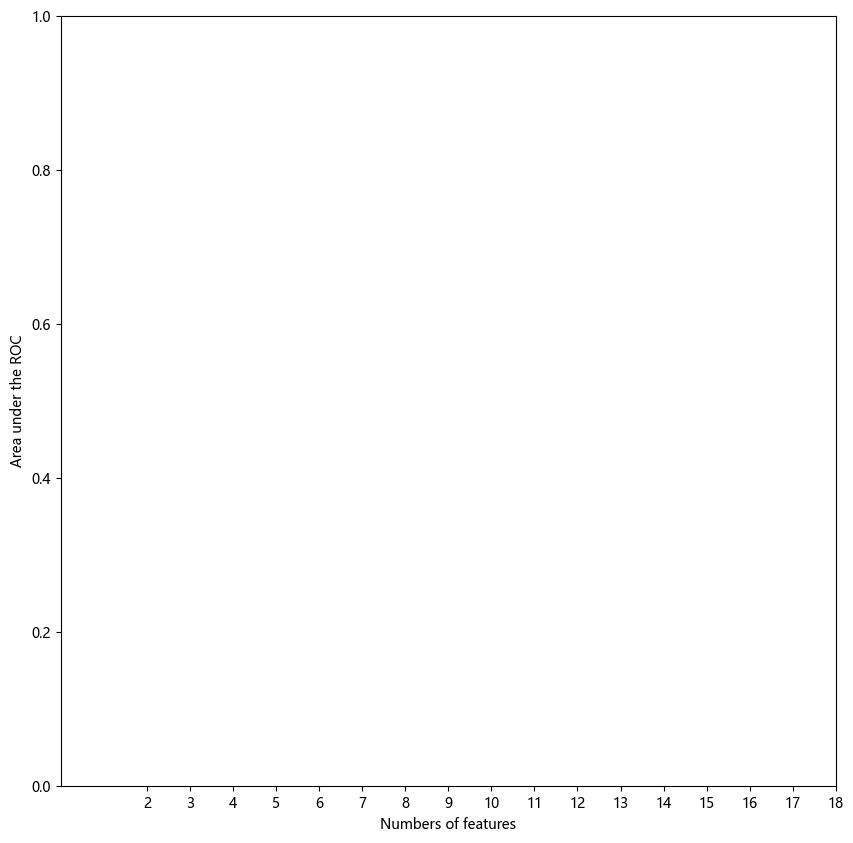

In [ ]:

print([importance])
result = {}
for index_i in range(len(importance)):
    X_drop = X.drop(X.columns[importance[:index_i]],axis=1)  
    k = 5
    for i in range(k):
        if i!=4:
            continue
        X_train, y_train, x_valid, y_valid,Y_index = get_k_fold_data(k,i,X_drop,Y,transform.confuse_index)
        pre = PredictWay(X_train, y_train, x_valid, y_valid,seed,Y_index)
        for model_name, model in ModelDict.items():
            matric = pre.model_train(model_name, model)
    for model_name, list_f_t in pre.dict_auc.items():
        result.setdefault(model_name,[]).append(auc(list_f_t[0], list_f_t[1]))
    print(result)


result['GBDT'].reverse()
result['LightGBM'].reverse()
result['SVM'].reverse()
result['DT'].reverse()
result['RF'].reverse()
# result['LR'].reverse()
result['KNN'].reverse()
result['ET'].reverse()
result['XGB'].reverse()
result['DNN'].reverse()
result['Ada'].reverse()
plt.figure(figsize=(10,10))
plt.xticks(range(2, 19, 1), labels=[str(i) for i in range(2, 19, 1)])
indice = np.arange(3, 19, 1)
plt.xlabel('Numbers of features')
plt.ylabel('Area under the ROC')
plt.plot(indice,result['GBDT'][2:19:1],':',label='GBDT')
plt.plot(indice,result['LightGBM'][2:19:1],'--',label='LightGBM')
plt.plot(indice,result['SVM'][2:19:1],'-.',label='SVM')
plt.plot(indice,result['DT'][2:19:1],'-',label='DT')
plt.plot(indice,result['RF'][2:19:1],'-.',label='RF')
plt.plot(indice,result['ET'][2:19:1],'-.',label='ET')
plt.plot(indice,result['Ada'][2:19:1],':',label='AdaBoost')
plt.plot(indice,result['DNN'][2:19:1],':',label='DNN')
plt.plot(indice,result['XGB'][2:19:1],':',label='XGB')
plt.plot(indice,result['KNN'][2:19:1],'--',label='KNN')
plt.scatter(indice,result['GBDT'][2:19:1],s=20)
plt.scatter(indice,result['LightGBM'][2:19:1],s=20)
plt.scatter(indice,result['SVM'][2:19:1],s=20)
plt.scatter(indice,result['DT'][2:19:1],s=20)
plt.scatter(indice,result['RF'][2:19:1],s=20)
plt.scatter(indice,result['ET'][2:19:1],s=20)
plt.scatter(indice,result['XGB'][2:19:1],s=20)
plt.scatter(indice,result['Ada'][2:19:1],s=20)
plt.scatter(indice,result['DNN'][2:19:1],s=20)
plt.scatter(indice,result['KNN'][2:19:1],s=20)

plt.axvline(11,c='black',ls='-.')
plt.legend()
plt.show()

LightGBM P: TtestResult(statistic=0.24827844524101983, pvalue=0.8041180190666222, df=256.0)
LightGBM P: TtestResult(statistic=0.4970958128009591, pvalue=0.6195481279649632, df=256.0)
LightGBM P: TtestResult(statistic=0.7468160448149381, pvalue=0.4558599364661775, df=256.0)
LightGBM P: TtestResult(statistic=0.6218200883934413, pvalue=0.5346135459973164, df=256.0)
LightGBM P: TtestResult(statistic=0.7468160448149381, pvalue=0.4558599364661775, df=256.0)
LightGBM P: TtestResult(statistic=0.8721302686141198, pvalue=0.3839545313637063, df=256.0)
LightGBM P: TtestResult(statistic=0.7468160448149381, pvalue=0.4558599364661775, df=256.0)
LightGBM P: TtestResult(statistic=1.1239029738980328, pvalue=0.2621069781414886, df=256.0)
LightGBM P: TtestResult(statistic=0.7468160448149381, pvalue=0.4558599364661775, df=256.0)
LightGBM P: TtestResult(statistic=0.8721302686141198, pvalue=0.3839545313637063, df=256.0)
LightGBM P: TtestResult(statistic=0.9978099499200515, pvalue=0.31931373001473995, df=256.

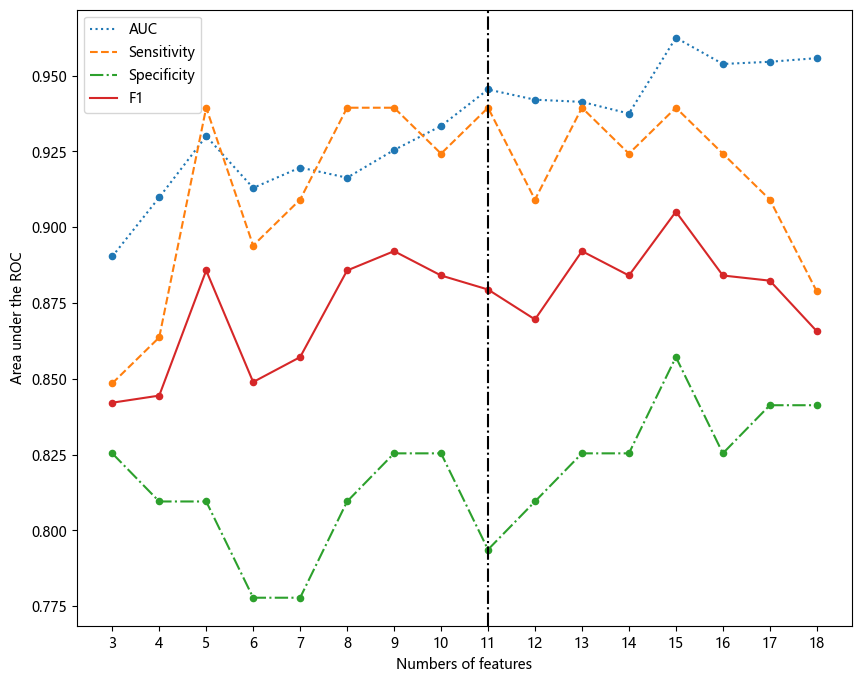

In [ ]:
result_metric = {
    'AUC':[],
    'Sensitivity':[],
    'Specificity':[],
    'F1':[],
    'PPV':[],
    'NPV':[],
    'Acc':[]
}
from scipy.stats import ttest_ind
result_imp = []
for index_i in range(len(importance)):
    X_in = X.drop(X.columns[importance[:index_i]],axis=1)  
    Xtest_in = test_x.drop(test_x.columns[importance[:index_i]],axis=1)  
    k = 5
    result_svm, result_gbdt,result_tree,result_randomtree,result_lg,result_knn,result_lgb = [],[], [], [],[],[],[]
    false_index = []
    for i in range(k):
        if i!=4:
            continue
        X_train, y_train, x_valid, y_valid,Y_index = get_k_fold_data(k,i,X_in,Y,transform.confuse_index)
        pre = PredictWay(X_train, y_train, x_valid, y_valid,seed,Y_index)
        sensitive,specificity,ppv,npv,acc,f1 = pre.model_train('LightGBM',lgb.LGBMClassifier(num_leaves=400,random_state=42,verbosity=-1))
        #  'LightGBM':lgb.LGBMClassifier(num_leaves=400,random_state=42,verbosity=-1)
        f,t = pre.dict_auc['LightGBM'][0], pre.dict_auc['LightGBM'][1]
        if X_train.shape[1]==18:
            result_imp.append([f,t,22,auc(f,t),None,None])
            auc0 = auc(f,t)
            result0 = pre.result
        if X_train.shape[1] in [11,10,9,3]:
            result_imp.append([f,t,X_train.shape[1],auc(f,t),auc0-auc(f,t),ttest_ind(auc(f,t), auc0)])
        # if X_train.shape[1]==10:
        #     result_imp.append([f,t,10,auc(f,t),0.0029,0.4131])
        # if X_train.shape[1]==9:
        #     result_imp.append([f,t,9,auc(f,t),0.0145,0.2090])
        # if X_train.shape[1]==3:
        #     result_imp.append([f,t,3,auc(f,t),0.1184,0.00015])
    result_metric['AUC'].append(auc(f,t))
    result_metric['Sensitivity'].append(sensitive)
    result_metric['Specificity'].append(specificity)
    result_metric['F1'].append(f1)
    result_metric['PPV'].append(ppv)
    result_metric['NPV'].append(npv)
    result_metric['Acc'].append(acc)
'''
画图
'''
result_metric['AUC'].reverse()
result_metric['Sensitivity'].reverse()
result_metric['Specificity'].reverse()
result_metric['F1'].reverse()
result_metric['NPV'].reverse()
result_metric['PPV'].reverse()
result_metric['Acc'].reverse()
plt.figure(figsize=(10,8))
plt.xticks(range(1,19,1), labels=[str(i) for i in range(1,19,1)])

print(result_metric['AUC'])
print(result_metric['Sensitivity'])
print(result_metric['Specificity'])
print(result_metric['F1'])
print(result_metric['NPV'])
print(result_metric['PPV'])
print(result_metric['Acc'])


indice = np.arange(3,19,1)
plt.xlabel('Numbers of features')
plt.ylabel('Area under the ROC')
plt.plot(indice,result_metric['AUC'][2:18:1],':',label='AUC')
plt.plot(indice,result_metric['Sensitivity'][2:18:1],'--',label='Sensitivity')
plt.plot(indice,result_metric['Specificity'][2:18:1],'-.',label='Specificity')
plt.plot(indice,result_metric['F1'][2:18:1],'-',label='F1')
plt.scatter(indice,result_metric['AUC'][2:18:1],s=20)
plt.scatter(indice,result_metric['Sensitivity'][2:18:1],s=20)
plt.scatter(indice,result_metric['Specificity'][2:18:1],s=20)
plt.scatter(indice,result_metric['F1'][2:18:1],s=20)
plt.axvline(11,c='black',ls='-.')
plt.legend()
plt.show()

In [57]:
pd.DataFrame(result_metric)

,AUC,Sensitivity,Specificity,F1,PPV,NPV,Acc
0,0.885762,0.878788,0.746032,0.828571,0.783784,0.854545,0.813953
1,0.887566,0.803030,0.809524,0.809160,0.815385,0.796875,0.806202
2,0.890332,0.848485,0.825397,0.842105,0.835821,0.838710,0.837209
3,0.909812,0.863636,0.809524,0.844444,0.826087,0.850000,0.837209
4,0.930014,0.939394,0.809524,0.885714,0.837838,0.927273,0.875969
5,0.912939,0.893939,0.777778,0.848921,0.808219,0.875000,0.837209
6,0.919673,0.909091,0.777778,0.857143,0.810811,0.890909,0.844961
7,0.916306,0.939394,0.809524,0.885714,0.837838,0.927273,0.875969
8,0.925445,0.939394,0.825397,0.892086,0.849315,0.928571,0.883721
9,0.933381,0.924242,0.825397,0.884058,0.847222,0.912281,0.875969
